In [1]:
import pandas as pd

bank_additional_full = pd.read_csv('Data/bank-additional/bank-additional/bank-additional-full.csv', delimiter=";") #all examples 100%

bank_additional_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Preprocessing:

In [2]:
from sklearn import preprocessing

bank_target = bank_additional_full['y']
bank_preprocessed = bank_additional_full.drop(columns='y')

label_encoder = preprocessing.LabelEncoder()
bank_target = label_encoder.fit_transform(bank_target) # encoded in 0 / 1

encoder = preprocessing.OneHotEncoder()
encoded = pd.DataFrame(encoder.fit_transform(bank_preprocessed[['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']]).toarray(),columns=encoder.get_feature_names_out(['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']))

bank_preprocessed = bank_preprocessed.drop(columns=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome'])
bank_preprocessed = pd.concat([bank_preprocessed,encoded],axis=1)
bank_preprocessed.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Train and test split:

In [3]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(bank_preprocessed,bank_target,test_size=0.2,random_state=42,stratify=bank_target)

# X_train = trainings data
# y_train = target for trainings data

# X_test = test data
# y_test = target for test data

Decision tree without and with max_depth=3:

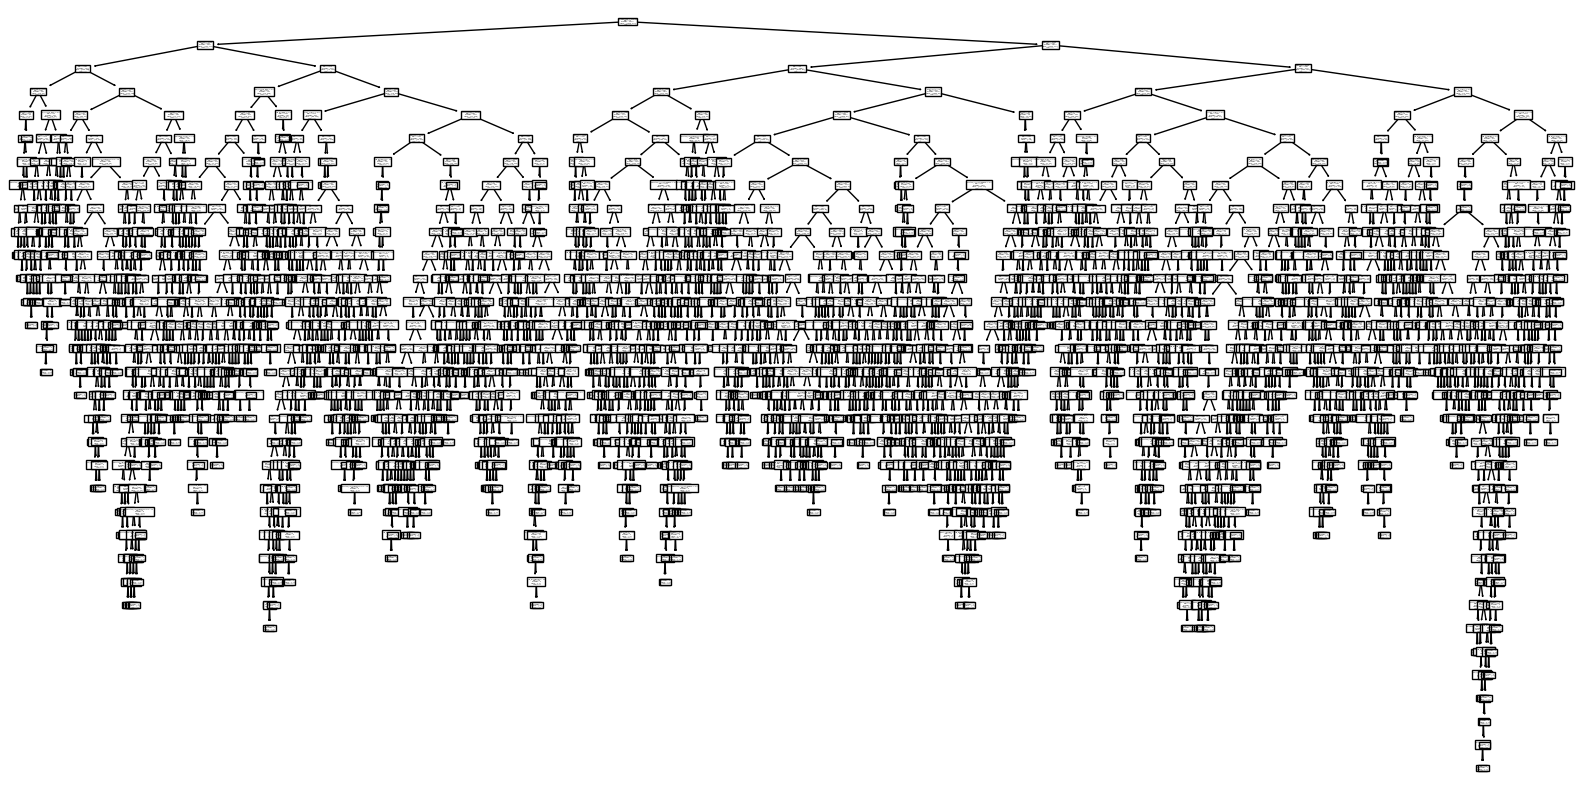

In [4]:
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

plt.figure(figsize=(20,10))
tree.plot_tree(dt,
               feature_names=bank_preprocessed.columns,
               class_names=label_encoder.classes_)
plt.show()

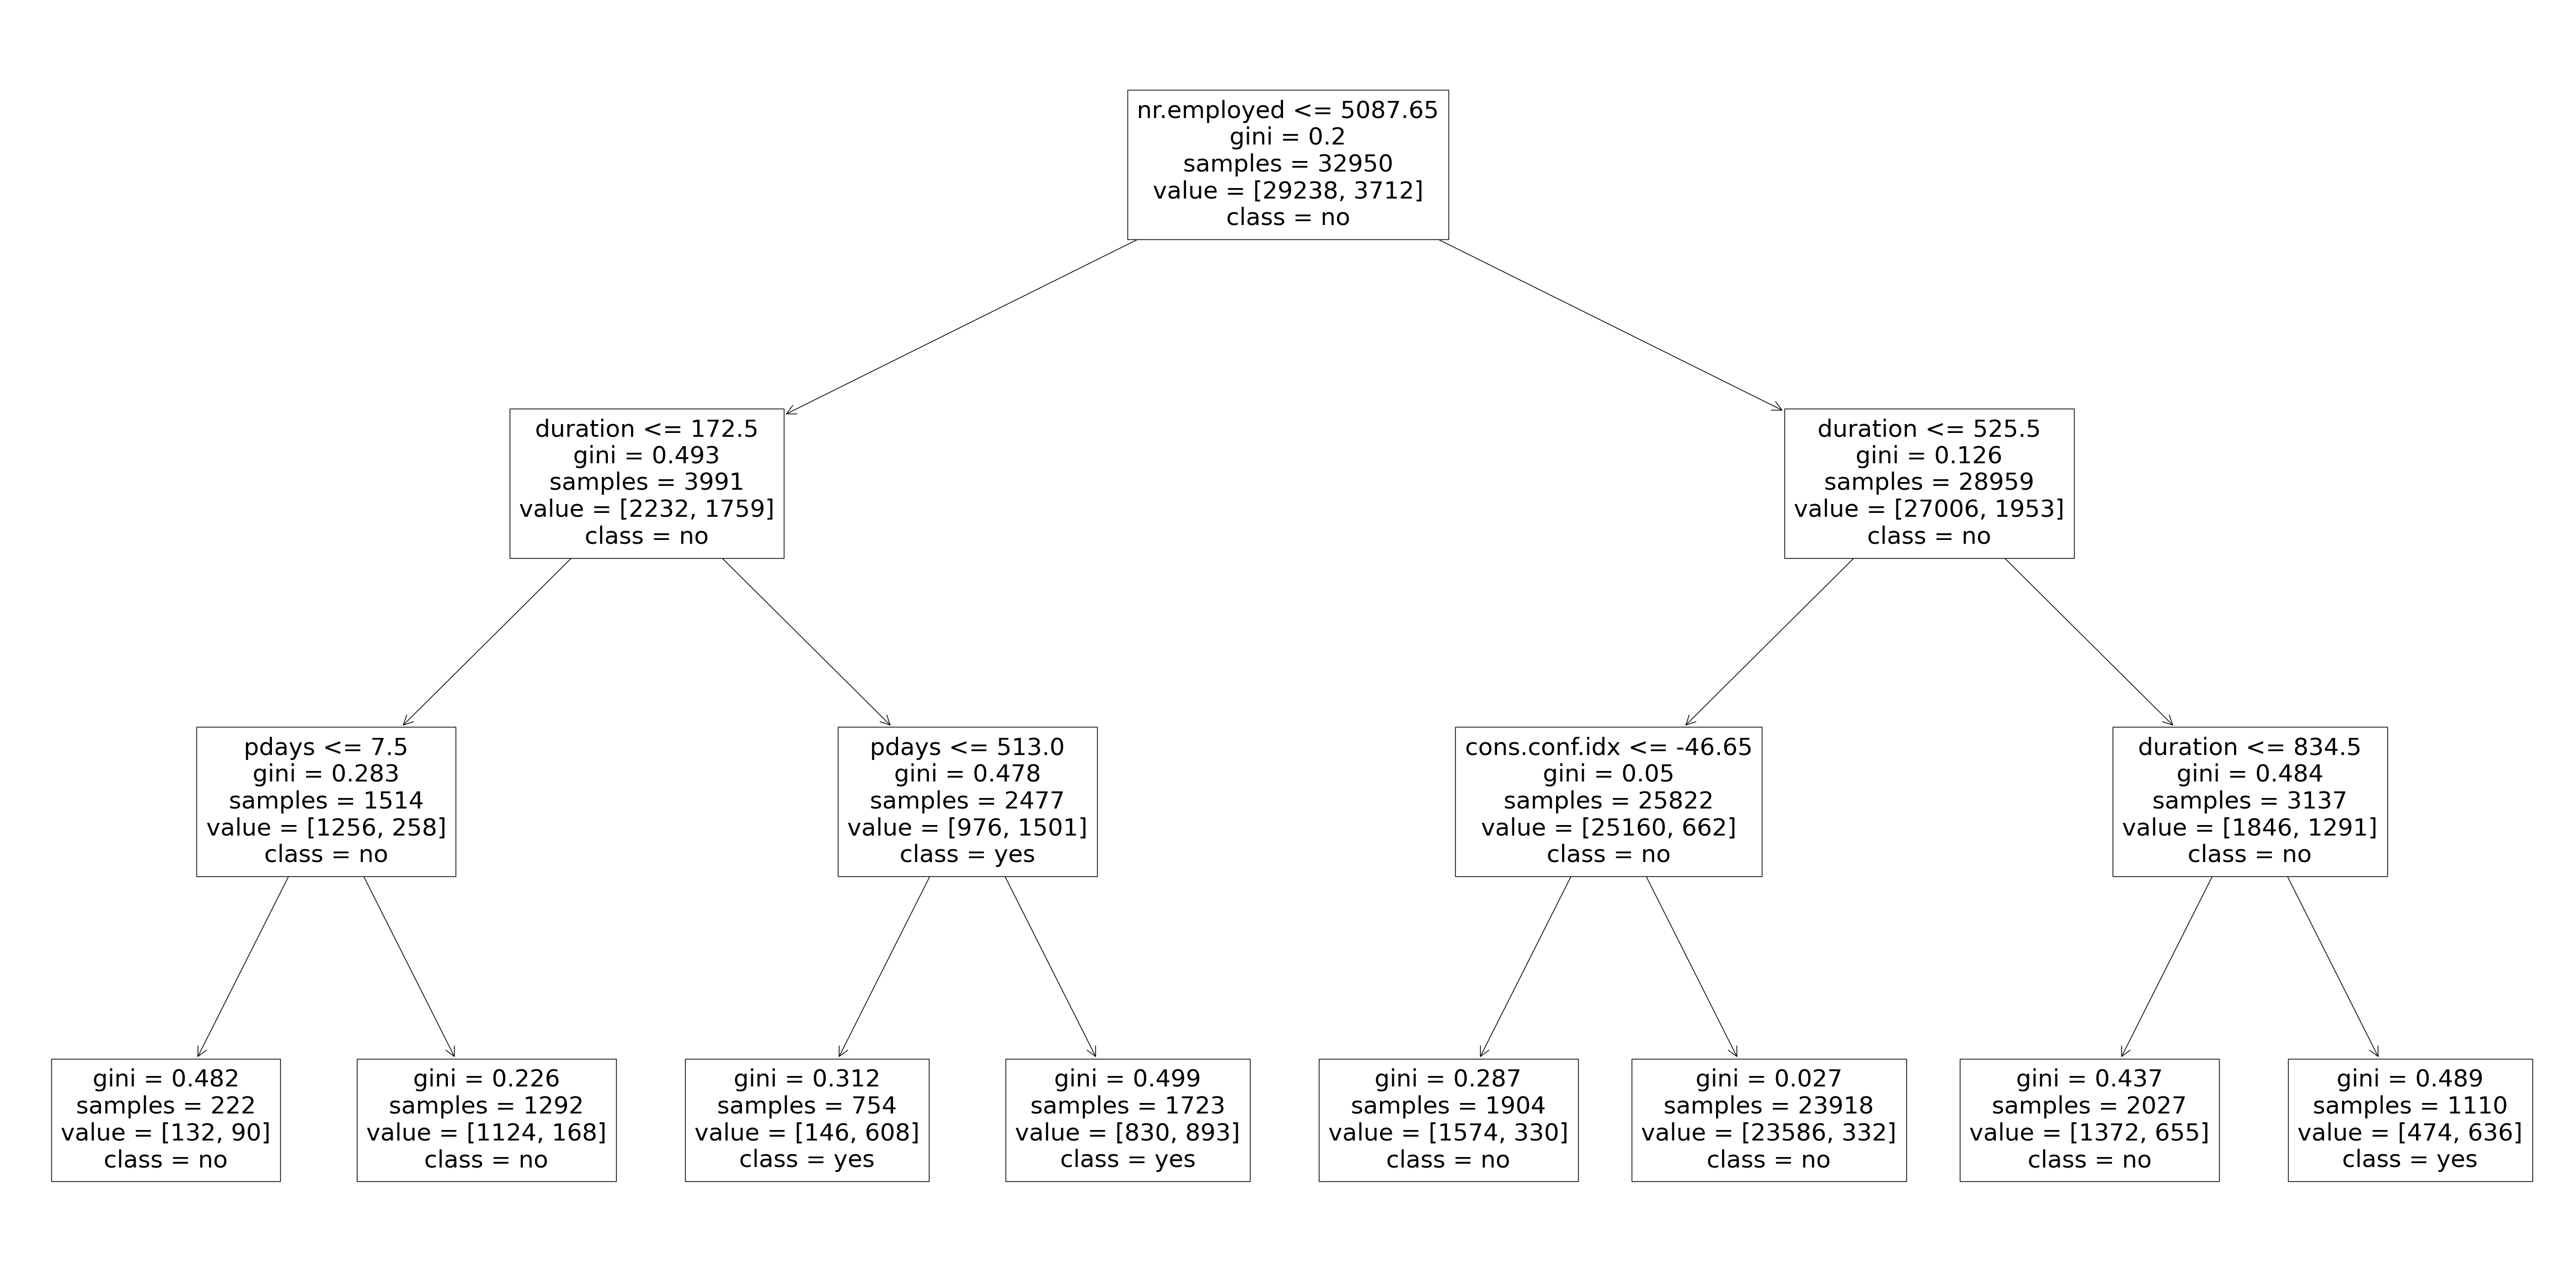

In [5]:
dt_maxDepth3 = DecisionTreeClassifier(max_depth=3)
dt_maxDepth3.fit(X_train, y_train)

plt.figure(figsize=(60,30))
tree.plot_tree(dt_maxDepth3,
               feature_names=bank_preprocessed.columns,
               class_names=label_encoder.classes_)
plt.show()

K-nearest-neighbor

k = 1, acc: 0.8900218499635834
k = 2, acc: 0.8994901675163874
k = 3, acc: 0.9059237679048313
k = 4, acc: 0.9053168244719592
k = 5, acc: 0.9077445982034474
k = 6, acc: 0.9079873755765963
k = 7, acc: 0.9099295945617868


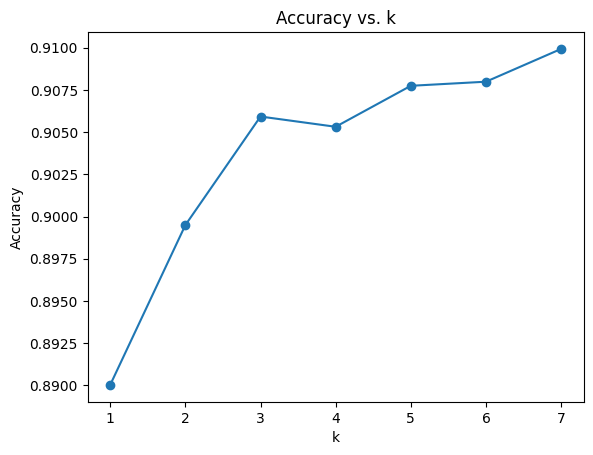

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 2, 3, 4, 5, 6, 7]
accuracy_scores = []

for n_neighbors in k_values:
    knn_estimator = KNeighborsClassifier(n_neighbors)
    knn_estimator.fit(X_train, y_train)
    bank_test_prediction = knn_estimator.predict(X_test)
    accuracy = accuracy_score(y_test, bank_test_prediction)
    accuracy_scores.append(accuracy)
    print("k = {}, acc: {}".format(n_neighbors, accuracy))

plt.plot(k_values, accuracy_scores, marker='o')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. k')
plt.show()